<a href="https://colab.research.google.com/github/n-vit/YaP_Projects/blob/main/%20pricing_auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [ ]:
# libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.stats import ttest_ind
import math
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from numpy import linalg as LA
import warnings
import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
#from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

# metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

## Подготовка данных

In [ ]:
try: # if the project is opened in Collab use a 'try' block, if it opened in simulator Yandex, or local Jupiter, use an 'except' block
    auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

except:
    auto = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [ ]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [ ]:
auto.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
auto.describe(include = "all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,NaT,NaT,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,NaT,NaT,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,NaT,NaT,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,NaT,NaT,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,NaT,NaT,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
auto.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


In [ ]:
auto['NumberOfPictures'].unique()

array([0])

### План предобработки:
похоже придется повозиться, и не сразу понятно, в каком порядке будет правильнее работать с фичами, поэтому сделаем чеклист и будем заполнять его по ходу:


- [x] Price - целевой признак: содержит нулевые цены в некоторых строках - изучить подробнее
- [x]  DateCrawled / DateCreated / LastSee - даты скачивания и создания анкеты, последней активности пользователя: перевести в формат даты (можно сразу в открытии)
- [x]  Проверить дубли в строках и дропнуть если будет что
- [x]  VehicleType - тип кузова: восстановить медиану по выбранной модели. Часто модель различается в зависимости от кузова
- [x]  Gearbox - тип КПП: восстановить медиану по модели
- [x]  Model - модель: восстановить медиану по бренду
- [x]  Power - мощность, содержит нулевые значения. Разобрать, восстановить или удалить. И еще похоже есть аномалии
- [x]  RegistrationYear содержит выбросы, год не может быть 1000 или 9999. Разобраться с выбросами
- [x]  NumberOfPictures - количество фото, везде только  0. Такая фича нам не нужна. Дропнуть колонку
- [x]  RegistrationMonth - месяц регистрации. Содержит значения с 1 по 12 и 0 (,более 10%). Месяц регистрации особенно для новых авто может влиять на цену. Нули заменить на nan
- [x]  PostalCode содержит в основном пятизначные числа, но есть и меньшее количество символов, возможно здесь ошибка. Нужно разобраться 
- [x]  FuelType - тип топлива: восстановить по мощности и бренду
- [x]  NotRepaired - не ремонтировался. Посмотреть на влияние на целевой признак в значениях [nan, 'yes', 'no']. Принять решение по восстановлению

- [x]  Повторно проверить форматы и пропуски, категоризировать object
- [x]  Понизить разрядность числовых данных, чтобы модель работала быстрее
- [x]  выделить таргет и фичи для обучения моделей
- [x]  Разбить на выборки (обучение/валидация/тест). 


Посмотрим на дубликаты, и дропнем полные повторы

In [ ]:
auto.duplicated().sum()

4

In [ ]:
auto = auto.drop_duplicates().reset_index(drop= True)

### Цена 

Сначала разберемся с целевым признаком. в нем есть нули. Возможно это ошибки, или пропуски, а возможно действительно машина в таком состоянии что ее просят забрать на металлолом. посмотрим ближе:

In [ ]:
auto.query('Price == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10772.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
RegistrationYear,10772.0,2008.848403,267.729824,1000.0,1996.00,2000.0,2005.00,9999.0
Power,10772.0,81.200056,235.273205,0.0,0.00,75.0,120.00,15016.0
Kilometer,10772.0,124177.961381,48423.379468,5000.0,125000.00,150000.0,150000.00,150000.0
RegistrationMonth,10772.0,3.697271,4.046864,0.0,0.00,2.0,7.00,12.0
NumberOfPictures,10772.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
PostalCode,10772.0,44937.204790,26395.784541,1069.0,25336.75,42855.0,63668.75,99996.0


Cтроки с нулевыми ценами содержат данные в широких диапазонах и включают ошибки и выбросы в каждом из показателей. 
Поскольку наша задача - научиться верно предсказывать таргет по остальным признакам - удалим строки с нулевым значением цены, и продолжим работу с остальным фреймом. 

In [ ]:
auto = auto.query('Price != 0')

###Выделим тестовую выборку до предобработки

In [ ]:
#df, test = train_test_split(auto, test_size=0.2, random_state=5)
#print('Выборка для обучения и валидации:', df.shape)
#print('Тестовая выборка:', test.shape)

<div class="alert alert-info">
<h2> Комментарий студента<a class="tocSkip"></h2>
<hr>  
Да, я столкнулся с этой загвоздкой при кодировании: некоторые признаки в обучающей и тестовой выборке различались (307 и 309 столбцов). 
Решил ее поиском различающихся признаков с помощью np.setdiff1d и удалением их 
    
Имеет ли такой подход право на жизнь?
    
В этом проекте убираю разделение выборок на этап после предобработки:

</div>

In [ ]:
df = auto

### Мощность

Посмотрим, сколько авто зарегистрировано с нулевыми значениями мощности, и что это за машины:

In [ ]:
df.query('Power==0').describe().T

,count,mean,std,min,25%,50%,75%,max
Price,36360.0,2402.729703,3115.886409,1.0,550.0,1292.5,2900.0,20000.0
RegistrationYear,36360.0,2008.866062,220.264464,1000.0,1998.0,2001.0,2007.0,9999.0
Power,36360.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Kilometer,36360.0,127778.465347,43356.971962,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,36360.0,4.213669,4.118534,0.0,0.0,3.0,8.0,12.0
NumberOfPictures,36360.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,36360.0,46743.643152,25197.068851,1067.0,26689.0,45665.0,65439.0,99998.0


<AxesSubplot:xlabel='Kilometer', ylabel='Count'>

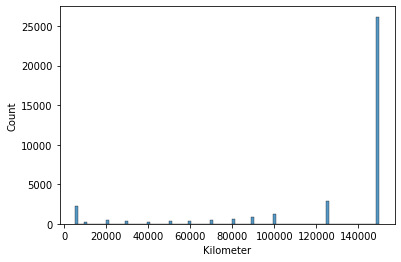

In [ ]:
sns.histplot(data=df.query('Power==0'), x="Kilometer")

Значительная часть строк с нулями в мощности - у машин с пробегом 150 000

In [ ]:
df.query('Power!=0').corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.088324,0.135171,-0.384265,0.071950,NaN,0.064668
RegistrationYear,0.088324,1.000000,0.012407,-0.074331,-0.000074,NaN,0.002217
Power,0.135171,0.012407,1.000000,0.022647,0.010064,NaN,0.010984
Kilometer,-0.384265,-0.074331,0.022647,1.000000,-0.015144,NaN,-0.010749
RegistrationMonth,0.071950,-0.000074,0.010064,-0.015144,1.000000,NaN,0.003177
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.064668,0.002217,0.010984,-0.010749,0.003177,NaN,1.000000


Корреляция ненулевой мощности с другими числовыми показателями отсутствует

In [ ]:
df.query('Power==0')['Brand'].value_counts()

volkswagen        7379
opel              4563
mercedes_benz     3293
ford              3003
renault           2776
bmw               2681
audi              2151
fiat              1344
peugeot           1108
sonstige_autos     939
nissan             623
citroen            601
mazda              579
seat               567
smart              554
toyota             412
skoda              377
mitsubishi         341
hyundai            334
suzuki             255
honda              248
kia                245
volvo              245
trabant            200
chevrolet          198
alfa_romeo         191
chrysler           169
daihatsu           139
mini               108
daewoo             104
porsche            102
rover               76
subaru              72
dacia               66
land_rover          64
jeep                62
lancia              56
lada                54
jaguar              51
saab                30
Name: Brand, dtype: int64

Все бренды будут в гости к нам... Возьмем для восстановления пропусков медиану по марке авто: как правило три-четыре версии двигателей ставятся на все модели в разных кузовах. 

In [ ]:
df['Power'] = df['Power'].replace(0, np.nan)
df['Power'] = df['Power'].astype(float)
print('Пропусков в мощности до восстановления:', df['Power'].isna().sum())

df['Power'] = df['Power'].fillna(df.groupby(['Brand'])['Power'].transform('median'))
print('Пропусков в мощности после восстановления по марке:', df['Power'].isna().sum())


Пропусков в мощности до восстановления: 36360
Пропусков в мощности после восстановления по марке: 0


Посмотрим на разброс значений мощности

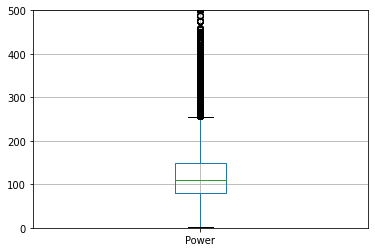

In [ ]:
plt.ylim(0, 500)
df.boxplot(column='Power')
plt.show()

есть длинный хвост ошибок, удалим строки с мощностью более 500 л.с. Таких авто немного, это нестандартные машины и на них действуют другие правила ценообразования. 

In [ ]:
df.query('Power > 500')['Power'].count()

429

In [ ]:
df = df.query('Power < 500')

###Модель

Восстановим пропуски в модели авто, выбрав наиболее частую модель для указанной марки. 

В процессе поисков возможного решения появлялась ошибка:

 *if is_scalar(key) and isna(key) and not self.hasnans:*

*KeyError: 'sonstige_autos'*

Это значит, что для марки 'sonstige_autos' вообще нет ни одной модели. В переводе с немецкого это означает "другие машины". 
Посмотрим на количество и удалим эти строки, если их немного, или поставим заглушку в данных о модели:

In [ ]:
df.loc[df['Brand'] == 'sonstige_autos',:].isna().sum()

DateCrawled             0
Price                   0
VehicleType           647
RegistrationYear        0
Gearbox               697
Power                   0
Model                2838
Kilometer               0
RegistrationMonth       0
FuelType              724
Brand                   0
NotRepaired           905
DateCreated             0
NumberOfPictures        0
PostalCode              0
LastSeen                0
dtype: int64

Пропусков в модели довольно много, а остальные данные в основном присутствуют, поэтому просто поставим заглушку в модели - sonstige_autos

In [ ]:
df.loc[df['Brand'] == 'sonstige_autos', ['Model']] = 'sonstige_autos'

In [ ]:
def by_sign_recovery(row, target_number, pivot_target, sign_number):
# Функция восстанавливает значение целевого признака по признаку-донору
# Принимает на входе:
# row - строку
# sign_number - номер столбца восстанавливаемого признака
# pivot_target - сводную таблицу фрейма по признаку-донору
# target_number - номер столбца признака-донора
    brand = row[sign_number]
    recover = row[target_number]
    if row[target_number] == 0:
        recover = pivot_target[brand].idxmax()
    return recover

In [ ]:
df['Model'].value_counts()
pivot_model = df.pivot_table(index=['Model'],
                             columns=['Brand'],
                             values=['Price'],
                             aggfunc=['count'])
pivot_model = pivot_model['count']['Price']
display(pivot_model.head(5))
df.fillna({'Model':0},inplace=True)

df['Model'] = df.apply(by_sign_recovery,
                       args=[6, pivot_model,10],
                       axis=1)
display(df['Model'].isna().sum())

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
Model,,,,,,,,,,,,,,,,,,,,,
100,NaN,396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,604.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0

### Кузов

Похоже шалость удалась. и теперь так же можно будет восстановить пропущенные данные о кузове, только кузов лучше определяется по модели, а не бренду:

In [ ]:
df['VehicleType'].isna().sum()

33677

In [ ]:
pivot_vehicle = df.pivot_table(index=['VehicleType'],
                               columns=['Model'],
                               values=['Price'],
                               aggfunc=['count'])
pivot_vehicle = pivot_vehicle['count']['Price']
display(pivot_vehicle)

Model,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,...,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,35.0,NaN,...,NaN,3.0,1.0,NaN,NaN,48.0,NaN,NaN,NaN,2370.0
convertible,1.0,NaN,NaN,NaN,NaN,6.0,251.0,1.0,1603.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,1.0,646.0,1.0
coupe,2.0,2.0,26.0,19.0,NaN,3.0,243.0,NaN,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,50.0,1.0
other,NaN,1.0,7.0,2.0,NaN,1.0,20.0,NaN,20.0,NaN,...,1.0,1.0,1.0,NaN,NaN,5.0,2.0,NaN,NaN,22.0
sedan,264.0,12.0,358.0,307.0,55.0,30.0,2640.0,15.0,256.0,59.0,...,NaN,725.0,NaN,125.0,3.0,46.0,NaN,3.0,1.0,22.0
small,NaN,19.0,93.0,8.0,NaN,1064.0,138.0,NaN,2753.0,NaN,...,NaN,NaN,NaN,NaN,NaN,913.0,NaN,185.0,NaN,11.0
suv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,...,93.0,775.0,196.0,NaN,216.0,8.0,168.0,NaN,NaN,7.0
wagon,104.0,NaN,2.0,299.0,144.0,53.0,20.0,1.0,347.0,69.0,...,NaN,8.0,NaN,30.0,41.0,19.0,1.0,2.0,NaN,223.0


In [ ]:
df.fillna({'VehicleType':0},inplace=True)
df['VehicleType'] = df.apply(by_sign_recovery,
                             args=[2, pivot_vehicle,6],
                             axis=1)
display(df['VehicleType'].isna().sum())

0

###Год регистрации

Разберемся с диапазоном данных о годе регистрации авто.

В обзоре фрейма (describe) мы видели, что последняя запись была создана в 2016 году, значит все годы регистрации указанные позднее - ошибки. Что касается более старых машин - посмотрим на стат. погрешности и логику: первые автомобили стали выпускаться в конце 18 века, а сейчас самые старые используемые авто можно встретить 60-70 г.г. Все что старше и еще эксплуатируется -явно относится к автораритетам и оценивается по другим признакам (сохранность, аутентичность и т.п.) 

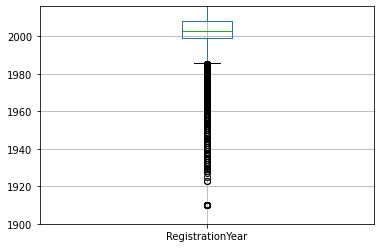

In [ ]:
plt.ylim(1900, 2016)
df.boxplot(column='RegistrationYear')
plt.show()

In [ ]:
print(df.query('RegistrationYear > 2016')['RegistrationYear'].count())

13748


График показывает, что статистически значимые авто зарегистрированы в 1980-х и позднее, но есть вероятность встретить и реальные машины постарше.
Строк с ошибочной регистрацией позже создания фрейма - более 10 тыс. 

Посмотрим сколько строк попадают в стат. выбросы старше 1960 г:



In [ ]:
print(df.query('RegistrationYear < 1960 & RegistrationYear > 1900')['RegistrationYear'].count())

284


Явные ошибки попробуем восстановить модой для модели, а пару сотен строк со стат. выбросами от 1900 до 1960 г. (менее 1%)- удалим из фрейма. Если они и существуют - их ценность скорее коллекционная, и их слишком мало чтобы учитывать это в модели

In [ ]:
pivot_year = df.query(
    'RegistrationYear > 1959 & RegistrationYear < 2017').pivot_table(
        index=['RegistrationYear'],
        columns=['Model'],
        values=['Price'],
        aggfunc=['count'])
pivot_year = pivot_year['count']['Price']
display(pivot_year.T.head(5))

RegistrationYear,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Model,,,,,,,,,,,,,,,,,,,,,
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
145,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.0,16.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,25.0
156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,1.0,28.0
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.0,33.0,15.0,13.0,6.0,2.0,NaN,NaN,NaN,2.0


In [ ]:
df.loc[df['RegistrationYear'] > 2016, ['RegistrationYear']] = 0
df.loc[df['RegistrationYear'] < 1960, ['RegistrationYear']] = 0

df['RegistrationYear'] = df.apply(by_sign_recovery,
                             args=[3, pivot_year,6],
                             axis=1)
display(df.loc[df['RegistrationYear'] == 0, ['RegistrationYear']].count() )

RegistrationYear    0
dtype: int64

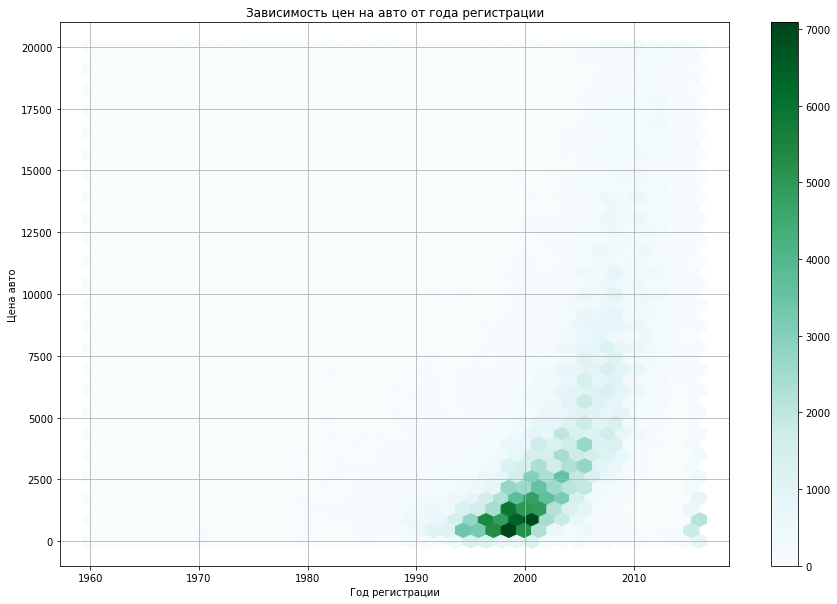

In [ ]:
df.plot(x='RegistrationYear', y='Price', kind='hexbin', gridsize=40
              , figsize=(15, 10), sharex=False, grid=True)
plt.title('Зависимость цен на авто от года регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Цена авто')
plt.show()

 Разброс цен в зависимости от года похож на правду: для авто каждого года есть машины с различными ценами, чем новее, тем дороже, максимум значений иприходится на конец 90-х начало нулевых, плюс заметный пик объявлений о продаже новых авто. 

### Тип коробки передач

Вариантов немного: ручка или автомат. Воспользуемся уже привычным способом и поставим самый популярный вариант по модели

In [ ]:
pivot_gearbox = df.pivot_table(
        index=['Gearbox'],
        columns=['Model'],
        values=['Price'],
        aggfunc=['count'])
pivot_gearbox = pivot_gearbox['count']['Price']
display(pivot_gearbox.T.head(5))

Gearbox,auto,manual
Model,,
100,59.0,320.0
145,NaN,39.0
147,26.0,516.0
156,50.0,629.0
159,26.0,182.0


In [ ]:
df.fillna({'Gearbox':0},inplace=True)
df['Gearbox'] = df.apply(by_sign_recovery,
                             args=[4, pivot_gearbox,6],
                             axis=1)
display(df['Gearbox'].value_counts())

manual    276733
auto       66395
Name: Gearbox, dtype: int64

Отлично. У нас только ручка или авто, поэтому данные можно было бы категоризировать признак в булев тип в одном столбце, но оставим это на следующий этап, т.к. предобработка тестовой и обучающей выборки должна быть одинаковой. 

### Тип топлива

Восстановим по наиболее популярной модели авто c этим топливом

In [ ]:
pivot_fueltype = df.pivot_table(
        index=['FuelType'],
        columns=['Model'],
        values=['Price'],
        aggfunc=['count'])
pivot_fueltype = pivot_fueltype['count']['Price']
display(pivot_fueltype)

Model,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,...,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0
electric,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gasoline,15.0,NaN,132.0,200.0,139.0,39.0,1642.0,NaN,670.0,79.0,...,12.0,1274.0,151.0,59.0,232.0,115.0,84.0,6.0,2.0,1187.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,1.0
lpg,8.0,NaN,18.0,17.0,NaN,4.0,9.0,NaN,41.0,11.0,...,4.0,32.0,1.0,8.0,4.0,1.0,NaN,1.0,10.0,82.0
other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
petrol,341.0,41.0,384.0,396.0,58.0,1125.0,1755.0,16.0,4346.0,42.0,...,79.0,212.0,42.0,89.0,25.0,941.0,87.0,185.0,678.0,1362.0


In [ ]:
df.fillna({'FuelType':0},inplace=True)
df['FuelType'] = df.apply(by_sign_recovery,
                             args=[9, pivot_fueltype,6],
                             axis=1)
display(df['FuelType'].value_counts())

petrol      235073
gasoline    101860
lpg           5160
cng            552
hybrid         227
other          169
electric        87
Name: FuelType, dtype: int64

### Информация о ремонте

У нас есть значения "нет", "да" и пропуски. Пропуски могут означать как то, что машина не ремонтировалась, так и то, что во фрейме нет данных о том, был ремонт, или нет. Посмотрим, как этот признак влияет на таргет, для этого возьмем срез из современных авто:

In [ ]:
df['NotRepaired'] = df['NotRepaired'].fillna(0)
df.groupby('NotRepaired')['Price'].mean()


NotRepaired
0      2835.661366
no     5371.223300
yes    2021.741736
Name: Price, dtype: float64

Машины, которые точно не ремонировали в среднем стоят вдвое дороже, чем те, что после ремонта, или с неуказанным признаком. Можно считать, что все машины, для которых не указаны значения "не ремонтировалась" - были в ремонте. Меняем пропуски назначение yes

In [ ]:
df['NotRepaired'] = df['NotRepaired'].replace(0, 'yes')

### Почтовый код

Почтовый код говорит о месте эксплуатации машины, это может оказывать заметное влияние на цену, т.к. авто лучше сохраняется в регионах с сухим теплым климатом. Соотношение спроса и предложения так же отличается от региона к региону, что тоже влияет на цену. Посмотрим какие встречаются почтовые коды отличные от пятизначных:

In [ ]:
df.query('PostalCode < 10000')['PostalCode'].value_counts().sum()

17079

In [ ]:
df['PostalCode'].value_counts()

10115    812
65428    604
66333    327
32257    304
44145    301
        ... 
23779      1
36169      1
82067      1
97780      1
94252      1
Name: PostalCode, Length: 8138, dtype: int64

Четырехзначных около 5% от фрейма. причем во многих случаях за четырехзначным кодом скрываются десятки машин, что не походит на случайную ошибку при заполнении. 

Тут есть еще одна загвоздка: это не числовой признак, и для обучения модели нужно будет категоризировать. Почтовые коды не зависят друг от друга, поэтому для каждого понадобится отдельный столбец... 

Не будем брать этот столбец в признаки для обучения, и посмотрим что из этого выйдет. Если результат будет приемлемым - ок. 


###Месяц регистрации

В данных о месяце регистрации есть нулевые значения. Посмотрим, насколько отличаются средние цифровые показатели машин для которых указан нулевой месяц, от остальных. Возможно просто пропущена единица в октябре...

In [ ]:
df.groupby('RegistrationMonth').mean().T


RegistrationMonth,0,1,2,3,4,5,6,7,8,9,10,11,12
Price,2163.766188,4784.621509,4681.789481,4658.960308,4838.905571,4722.964357,4804.377695,4894.544394,4768.045446,4962.875573,4898.305329,4993.112310,4712.021456
RegistrationYear,2000.299723,2002.612407,2003.007218,2002.739174,2002.832107,2002.846483,2002.798831,2002.289440,2003.064167,2003.108751,2003.032605,2003.123562,2002.730599
Power,109.697779,120.021076,117.274468,117.626846,119.765619,118.617471,120.347240,123.089875,119.209957,121.103568,121.325736,122.365418,121.680395
Kilometer,129649.419508,128556.689643,128039.649697,127365.546840,127673.282869,127822.487283,128236.525974,128335.522366,128061.182961,127874.030925,128695.609680,128526.908003,129796.610884
NumberOfPictures,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PostalCode,48013.367218,50604.338194,50923.398037,51513.612728,51687.534203,51048.624733,50751.032403,51515.852597,50212.511486,51293.102240,51250.956879,50589.493068,49776.699321


In [ ]:
df['RegistrationMonth'].value_counts()

3     33785
0     32817
6     30800
4     28667
5     28505
7     26648
10    25579
11    23729
12    23723
9     23347
1     22632
8     22114
2     20782
Name: RegistrationMonth, dtype: int64

нет, просто добавлять эти нули в октябрь будет неправильно. средняя цена, год регистрации и мощность не характерны ни для одного из месяцев, при этом ошибочных значений почти 10% от фрейма и больше, чем в остальных месяцах. 

удалять их тоже вредно. Месяц регистрации может влиять на цену (например машины зарегистрированные в конце года часто оцениваются дороже, чем те, которые зарегистрированы в начале того же года, т.к. меньше эксплуатировались на момент продажи, особенно это актуально для "свежих" машин

Стоит оставить информацию в таком виде и указать на ошибку в выводах

In [ ]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [ ]:
df.shape

(343128, 16)

In [ ]:
df.describe(include = "all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DateCrawled,343128,264882,2016-03-24 14:49:47,7,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,343128.0,NaN,NaN,NaN,NaT,NaT,4554.017338,4512.721193,1.0,1200.0,2890.0,6500.0,20000.0
VehicleType,343128,8,sedan,105599,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,343128.0,NaN,NaN,NaN,NaT,NaT,2002.594798,6.582391,1960.0,1999.0,2003.0,2007.0,2016.0
Gearbox,343128,2,manual,276733,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,343128.0,NaN,NaN,NaN,NaT,NaT,119.156799,51.378624,1.0,80.0,109.0,150.0,490.0
Model,343128,251,golf,31321,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,343128.0,NaN,NaN,NaN,NaT,NaT,128347.526288,37503.980322,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,343128.0,NaN,NaN,NaN,NaT,NaT,5.778019,3.69779,0.0,3.0,6.0,9.0,12.0
FuelType,343128,7,petrol,235073,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Результаты предобработки:



В результате предобработки исправлены ошибочно указанные данные в годе регистрации, восстановлены пропуски в информации о модели, кузове, типе кпп и топлива, информации о ремонте. 

В информации о месяцах содержатся нулевые значения, вероятнее всего это незаполненная информация, т.к. отнести эти строки к любому из месяцев оснований нет

В информации о почтовых индексах содержится более 13 тыс. строк с четырехзначными кодами, отличающимися от основной массы, в которой пять знаков. 



## Подготовка к работе с моделями:
- Выберем из фрейма нужные для обучения признаки
- Категоризируем признаки
- Уменьшим разрядность данных

Поскольку тестовая и учебная выборки должны быть предобработаны одинаково - решим эту задачу через функцию, принимающую "сырой" фрейм, и возвращающую набор фич и таргет для обучения


Из обучающей выборки можно удалить данные, которые не влияют на цену: 
- о дате выгрузки информации
- о последнем визите 
- о количестве фотографий (этот столбец пустой)

дату подачи объявления можно категоризировать до месяца, но внутри функции почему-то не работает (закомментил). сделаем отдельно до функции в учебной и тестовой выборке:

In [ ]:
def optimize_for_train(data):
#удаляем лишние колонки
    data = data.drop(['DateCrawled', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)

# даты категоризируем до месяцев
    data['DateCreated'] = data['DateCreated'].dt.month

#бинарные данные заменяем вручную на единицы и нули
    data['NotRepaired'] = data['NotRepaired'].replace('yes', 1)
    data['NotRepaired'] = data['NotRepaired'].replace('no', 0)
    data['Gearbox'] = data['Gearbox'].replace('auto', 1)
    data['Gearbox'] = data['Gearbox'].replace('manual', 0)

#категоризируем небинарные object данные
    data = pd.get_dummies(data, drop_first=True)

#понижаем разрядность числовых данных
    df_float = data.select_dtypes(include=['float']) 
    df_float = df_float.apply(pd.to_numeric,downcast='float')
    data[df_float.columns] = df_float

    df_int = data.select_dtypes(include=['int']) 
    df_int = df_int.apply(pd.to_numeric,downcast='unsigned') 
    data[df_int.columns] = df_int

# разделяем целевой признак и фичи
    target = data['Price']
    features = data.drop('Price', axis=1)
    return target, features

In [ ]:
target, features = optimize_for_train(df)
#test_target, test_features = optimize_for_train(test)

In [ ]:
#test_features.info()

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343128 entries, 0 to 354364
Columns: 309 entries, RegistrationYear to Brand_volvo
dtypes: float32(1), uint16(1), uint32(1), uint8(306)
memory usage: 106.0 MB


~Вот незадача. тестовая выборка в итоге отличается от обучающей. Выясним что это за признаки~

In [ ]:
#np.setdiff1d(features.columns, test_features.columns)

Удалим несовпадающие признаки

In [ ]:
#features = features.drop(['Model_serie_1', 'Model_serie_3', 'Model_sonstige_autos'], axis=1)

In [ ]:
#test_features = test_features.drop(['Model_range_rover_evoque'], axis=1)

In [ ]:
len(features.axes[1])

309

In [ ]:
#len(test_features.axes[1])

In [ ]:
#pd.set_option('display.max_columns', None)
#test_features.head(3)

In [ ]:
#pd.set_option('display.max_columns', None)
#features.head(3)

Выделим тестовую, тренировочную и валидационную выборки:

In [ ]:
features_train, features_valid, \
target_train, target_valid = train_test_split(features, target, 
                                              test_size=0.4, random_state=5)

features_test, features_valid, \
target_test, target_valid = train_test_split(features_valid, target_valid, 
                                              test_size=0.4, random_state=5)

## Обучение моделей и подбор параметров

### Линейная регрессия

In [ ]:
'''
%%time
regressor = LinearRegression()
lr_rmse = (cross_val_score(
    regressor,
    features_train,
    target_train,
    cv=5,
    scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE в линейной регрессии =', lr_rmse)
'''

"\n%%time\nregressor = LinearRegression()\nlr_rmse = (cross_val_score(\n    regressor,\n    features_train,\n    target_train,\n    cv=5,\n    scoring='neg_mean_squared_error').mean() * -1) ** 0.5\nprint('RMSE в линейной регрессии =', lr_rmse)\n"

Полученный результат:

*RMSE в линейной регрессии = 2706.3574661629973*

*CPU times: user 45.8 s, sys: 2.86 s, total: 48.6 s*

*Wall time: 28.3 s*

В задании нужно получить RMSE менее 2500. Линейная регрессия дает на 200 больше

### Решающее дерево

In [ ]:
'''
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры решающего дерева:")
print()
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

dtr_rmse = (max(means)*-1) ** 0.5
'''

'\n%%time\n\nregressor = DecisionTreeRegressor() \nmax_depth_list = [x for x in range(2, 31)]\nhyperparams = [{\'criterion\':[\'mse\'], \n                \'max_depth\':max_depth_list, \n                \'random_state\':[12345]}]\n\nclf = GridSearchCV(regressor, hyperparams, scoring=\'neg_mean_squared_error\')\nclf.fit(features_train, target_train)\nprint("Лучшие параметры решающего дерева:")\nprint()\nprint(clf.best_params_)\nprint()\nmeans = clf.cv_results_[\'mean_test_score\']\nstds = clf.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, clf.cv_results_[\'params\']):\n    print("%0.6f for %r"% ((mean*-1)** 0.5, params))\nprint()\n\ndtr_rmse = (max(means)*-1) ** 0.5\n'

Лучшие параметры решающего дерева (выполняется долго, поэтому закомментил):

*{'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}*

*CPU times: user 8min 57s, sys: 34.2 s, total: 9min 32s
Wall time: 9min 32s*

Наименьший RMSE с максимальной глубиной 14 вписывается в критерии задания. 

Попробуем бустинг. 

### LightGBM модель

In [ ]:
'''
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры модели LightGBM:")
print()
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

lgbm_rmse = (max(means)*-1) ** 0.5
'''

'\n%%time\n\nregressor = LGBMRegressor() \nhyperparams = [{\'num_leaves\':[31, 100, 200], \n                \'learning_rate\':[0.1, 0.3, 0.5],\n                \'random_state\':[12345]}]\n\nclf = GridSearchCV(regressor, hyperparams, scoring=\'neg_mean_squared_error\')\nclf.fit(features_train, target_train)\nprint("Лучшие параметры модели LightGBM:")\nprint()\nprint(clf.best_params_)\nprint()\nmeans = clf.cv_results_[\'mean_test_score\']\nstds = clf.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, clf.cv_results_[\'params\']):\n    print("%0.6f for %r"% ((mean*-1)** 0.5, params))\nprint()\n\nlgbm_rmse = (max(means)*-1) ** 0.5\n'

*Лучшие параметры модели LightGBM:*

*{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}*

*CPU times: user 8min 23s, sys: 15.5 s, total: 8min 38s
Wall time: 8min 45s*

rmse всего 1695, что соответствует ожиданиям заказчика

## Анализ моделей

Оценим время и среднеквадратичную ошибку моделей на валидационной выборке и определим лучшую модель

### Линейная регрессия

In [ ]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 15.1 s, sys: 4.18 s, total: 19.2 s
Wall time: 19.2 s


LinearRegression()

In [ ]:
%%time
target_predict = model_lr.predict(features_valid)

CPU times: user 77 ms, sys: 61.3 ms, total: 138 ms
Wall time: 104 ms


In [ ]:
valid_rmse_lr = mean_squared_error(target_valid, target_predict) ** 0.5
print(valid_rmse_lr)

2731.0144972843286


### Решающее дерево

In [ ]:
%%time

model_dtr = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=12345) 
model_dtr.fit(features_train, target_train)

CPU times: user 4.62 s, sys: 204 ms, total: 4.83 s
Wall time: 4.83 s


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [ ]:
%%time

target_predict = model_dtr.predict(features_valid)

CPU times: user 48.9 ms, sys: 57.7 ms, total: 107 ms
Wall time: 108 ms


In [ ]:
valid_rmse_dtr = mean_squared_error(target_valid, target_predict) ** 0.5  
print(valid_rmse_dtr)

2041.6311268848103


### LightGBM модель

In [ ]:
%%time

model_lgbm = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model_lgbm.fit(features_train, target_train)

CPU times: user 14.1 s, sys: 331 ms, total: 14.4 s
Wall time: 14.5 s


LGBMRegressor(num_leaves=200, random_state=12345)

In [ ]:
%%time

target_predict = model_lgbm.predict(features_valid)

CPU times: user 902 ms, sys: 71.7 ms, total: 974 ms
Wall time: 913 ms


In [ ]:
valid_rmse_lgbm = mean_squared_error(target_valid, target_predict) ** 0.5
print(valid_rmse_lgbm)

1707.990862338068


### Сравним результаты моделей

In [ ]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'LGBMRegressor']
data = {'RMSE на валидации':[valid_rmse_lr,
                            valid_rmse_dtr,
                            valid_rmse_lgbm],
        'Время обучения, сек':[17.9,
                               4.78,
                               14.1],
        'Время предсказания, сек':[0.141,
                                   0.108,
                                   0.998]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,RMSE на валидации,"Время обучения, сек","Время предсказания, сек"
LinearRegression,2731.014497,17.90,0.141
DecisionTreeRegressor,2041.631127,4.78,0.108
LGBMRegressor,1707.990862,14.10,0.998


Дерево учится немного быстрее, но градиентрый бустинг работает лучше всех и по времени предсказания, и по итоговому результату - менее 1700 евро на валидационной выборке

**Лучшая модель из протестированных - градиентный бустинг LightGBM**

## Проверим лучшую модель на тестовой выборке:

Обучим модель на полной выборке и предскажем цену тестовой выборки

In [ ]:
%%time
model_lgbm.fit(features_train, target_train)
test_predict = model_lgbm.predict(features_test)
test_rmsem = mean_squared_error(target_test, test_predict) ** 0.5
print(test_rmsem)

1665.6512254588552
CPU times: user 19.3 s, sys: 438 ms, total: 19.7 s
Wall time: 20 s


**Модель, полученная в результате отбора и обучения - соответствует заявленным критериям заказчика и может быть применена на необработанных данных**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей